In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import datetime

x_train = pd.read_csv("sales_train.csv")
y_test = pd.read_csv("test.csv")

print("Train data shape: ", x_train.head())
print("Test data shape: ", y_test.head())

Train data shape:           date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
Test data shape:     ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


Importing plotly failed. Interactive plots will not work.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


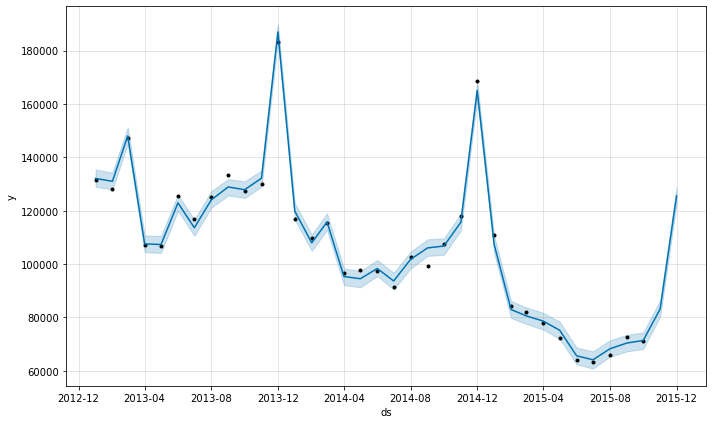

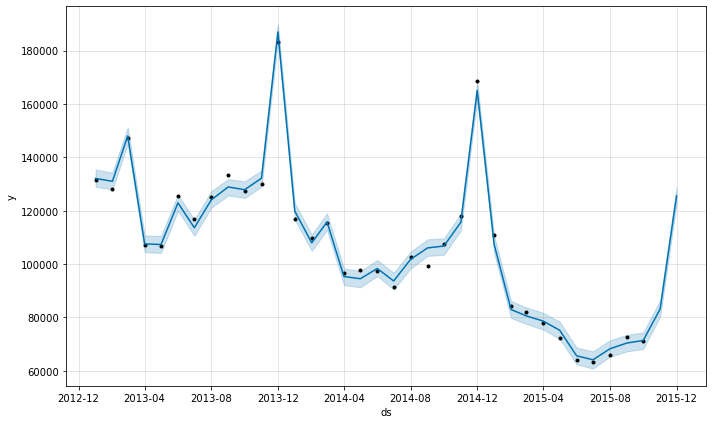

In [2]:
#Prophet (tool used to look at future trends)
#This is what general results should look like

ts=x_train
ts=x_train.groupby(["date_block_num"])["item_cnt_day"].sum()

ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

from fbprophet import Prophet

ts.columns=['ds','y']
model = Prophet(yearly_seasonality = True)
model.fit(ts)

# prediction
future = model.make_future_dataframe(periods = 2, freq = 'MS')  
forecast = model.predict(future)
model.plot(forecast)

In [3]:
#turn data into monthly data 

x_train['date'] = pd.to_datetime(x_train['date'], format='%d.%m.%Y')
x_train['month'] = x_train['date'].dt.month
x_train['year'] = x_train['date'].dt.year
x_train = x_train.drop(['date', 'item_price'], axis=1)
x_train = x_train.groupby([c for c in x_train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
x_train = x_train.rename(columns={'item_cnt_day':'item_cnt_month'})

#find the mean
item_mean = x_train[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False)[['item_cnt_month']].mean()
item_mean = item_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})

#add to the training data
x_train = pd.merge(x_train, item_mean, how='left', on=['shop_id', 'item_id'])

y_test['year'] = 2015
y_test['date_block_num'] = 34
y_test = pd.merge(y_test, item_mean, how='left', on=['shop_id', 'item_id'])
y_test = y_test.fillna(0.)
#print(y_test)


In [4]:
#Random Forest training
feature_list = [i for i in x_train.columns if i not in 'item_cnt_month']

x1 = x_train[x_train['date_block_num'] < 33]
y1 = x1['item_cnt_month']


from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10,  n_jobs=-1, verbose = 1)
rf.fit(x1, y1)

#Full train
rf.fit(x_train[feature_list], x_train['item_cnt_month'])
accuracy = rf.score(x_train[feature_list], x_train['item_cnt_month'])
print("Accuracy: ",accuracy*100 )


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   43.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Accuracy:  94.34077004704872


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.5s finished


In [5]:
#use the model to make predictions on each item
y_test['item_cnt_month'] = rf.predict(y_test[feature_list]).clip(0., 20.)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


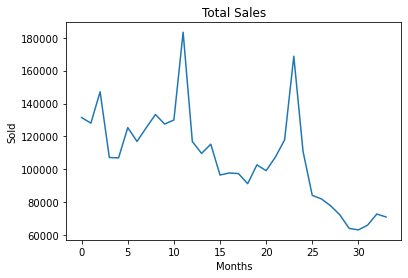

In [6]:
#Looking at sales trends by months
import matplotlib.pyplot as plt

monthly_sales=x_train.groupby(["date_block_num"])["item_cnt_month" ].sum()
#ts.astype('float')
#plt.figure(figsize=(16,8))
plt.title('Total Sales')
plt.xlabel('Months')
plt.ylabel('Sold')
plt.plot(monthly_sales);


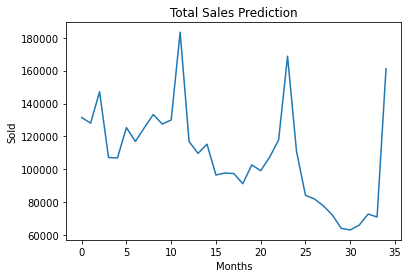

In [7]:
#Add the predicted data to the training data
combined_results = ( x_train, y_test)
total_results=pd.concat(combined_results)
monthly_sales=total_results.groupby(["date_block_num"])["item_cnt_month"].sum()

plt.title('Total Sales Prediction')
plt.xlabel('Months')
plt.ylabel('Sold')
plt.plot(monthly_sales);

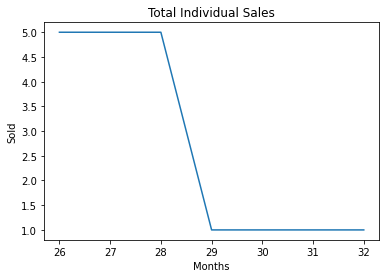

In [8]:
#looking at individual item id's total sum over time
import matplotlib.pyplot as plt

item_id = 6371   #Change this number to look at other items

analysis_df = x_train
analysis_df = analysis_df[analysis_df['item_id'] == item_id]
pre=analysis_df.groupby(["date_block_num"])["item_cnt_month" ].sum()

plt.title('Total Individual Sales',)
plt.xlabel('Months')
plt.ylabel('Sold')
plt.plot(pre);


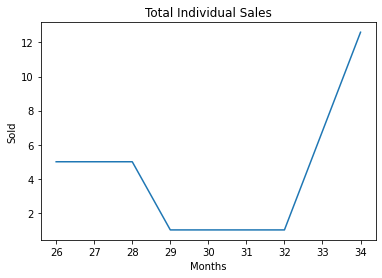

In [9]:
#Same graph but continued after the model prediction

post_analysis_df = total_results
post_analysis_df = post_analysis_df[post_analysis_df['item_id'] == item_id]
post=post_analysis_df.groupby(["date_block_num"])["item_cnt_month" ].sum()

plt.title('Total Individual Sales')
plt.xlabel('Months')
plt.ylabel('Sold')
plt.plot(post);

In [10]:
# Find the most important features

important_features = list(rf.feature_importances_)
print('Importances: ', important_features)
print('Features: ', feature_list)

Importances:  [0.1661321840375818, 0.04379427920802712, 0.09721563853927119, 0.014190732900429475, 0.6786671653146904]
Features:  ['date_block_num', 'shop_id', 'item_id', 'year', 'item_cnt_month_mean']
